In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

<h1>Train your first neural network: basic classification</h1>

View on TensorFlow.org	Run in Google Colab	View source on GitHub
This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details, this is a fast-paced overview of a complete TensorFlow program with the details explained as we go.

This guide uses <a href="https://www.tensorflow.org/guide/keras">tf.keras</a>, a high-level API to build and train models in TensorFlow.



In [16]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

print(tf.__version__)

1.13.0-rc1


<h1>Import the Fashion MNIST dataset</h1>

This guide uses the <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion MNIST</a> dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:
<img src="https://camo.githubusercontent.com/d6c9bc0facf72b81485fcbe34c6df27efcf895b5/68747470733a2f2f74656e736f72666c6f772e6f72672f696d616765732f66617368696f6e2d6d6e6973742d7370726974652e706e67"/>

<p>Fashion MNIST is intended as a drop-in replacement for the classic MNIST dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.</p>

<p>This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.</p>

<p>We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow, just import and load the data:</p>

In [5]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Loading the dataset returns four NumPy arrays:

* The train_images and train_labels arrays are the training set—the data the model uses to learn.
* The model is tested against the test set, the test_images, and test_labels arrays.

The images are 28x28 NumPy arrays, with pixel values ranging between 0 and 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label|Class      |
|-----|-----------|
|    0|T-shirt/top|
|    1|    Trouser|
|    2|   Pullover|
|    3|      Dress|
|    4|       Coat|
|    5|     Sandal|
|    6|      Shirt|
|    7|    Sneaker|
|    8|        Bag|
|    9|Ankle boot|

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

<h2>Explore the data</h2>

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [9]:
train_images.shape

(60000, 28, 28)

Likewise, there are 60,000 labels in the training set:

In [10]:
len(train_images)

60000

Each label is an integer between 0 and 9:

In [12]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:


In [13]:
test_images.shape

(10000, 28, 28)

And the test set contains 10,000 images labels:

In [15]:
len(test_labels)

10000

<h2>Preprocess the Data</h2>

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

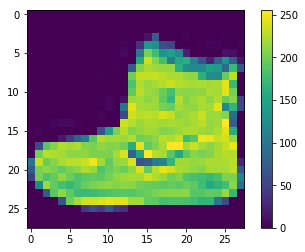

In [17]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

We scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the training set and the testing set are preprocessed in the same way:

In [18]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

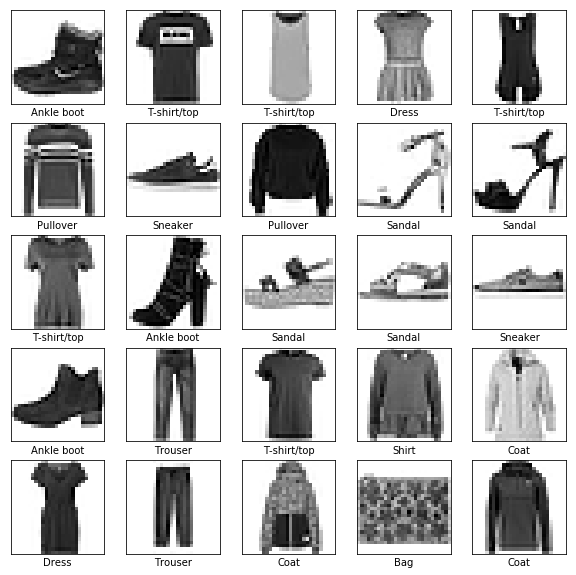

In [19]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

<h2> Build the model </h2>

Building the neural network requires configuring the layers of the model, then compiling the model.

<h3>Setup the layers</h3>

The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. And, hopefully, these representations are more meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, like tf.keras.layers.Dense, have parameters that are learned during training.

In [20]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

Instructions for updating:
Colocations handled automatically by placer.


The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a 2d-array (of 28 by 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two tf.keras.layers.Dense layers. These are densely-connected, or fully-connected, neural layers. The first Dense layer has 128 nodes (or neurons). The second (and last) layer is a 10-node softmax layer—this returns an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

<h3>Compile the Model</h3>

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

* Loss function —This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
* Optimizer —This is how the model is updated based on the data it sees and its loss function.
* Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [23]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

<h3>Train the Model</h3>

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the train_images and train_labels arrays.
2. The model learns to associate images and labels.
3. We ask the model to make predictions about a test set—in this example, the test_images array. We verify that the predictions match the labels from the test_labels array.

To start training, call the model.fit method—the model is "fit" to the training data:

In [25]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 17s 292us/sample - loss: 0.4937 - acc: 0.8266
Epoch 2/5
60000/60000 [==============================] - 17s 285us/sample - loss: 0.3701 - acc: 0.8656
Epoch 3/5
60000/60000 [==============================] - 17s 284us/sample - loss: 0.3349 - acc: 0.8773
Epoch 4/5
60000/60000 [==============================] - 17s 287us/sample - loss: 0.3108 - acc: 0.8849
Epoch 5/5
60000/60000 [==============================] - 17s 285us/sample - loss: 0.2927 - acc: 0.8924


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.88 (or 88%) on the training data.

<h3>Evaluate the Model</h3>

Next, compare how the model performs on the test dataset:

In [26]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test accuracy: ", test_acc)

10000/10000 [==============================] - 2s 181us/sample - loss: 0.3566 - acc: 0.8761
Test accuracy:  0.8761


It turns out, the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of overfitting. Overfitting is when a machine learning model performs worse on new data than on their training data.

<h3>Make Predictions</h3>

With the model trained, we can use it to make predictions about some images.

In [27]:
predictions = model.predict(test_images)

In [28]:
predictions[0]

array([7.3580190e-07, 3.9332033e-08, 1.1762108e-06, 6.5100716e-07,
       2.4366994e-07, 9.2866328e-03, 2.1586918e-06, 5.5848882e-02,
       5.2370820e-06, 9.3485427e-01], dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [29]:
np.argmax(predictions[0])

9

So the model is most confident that this image is an ankle boot, or class_names[9]. And we can check the test label to see this is correct:

In [30]:
test_labels[0]

9

We can graph this to look at the full set of 10 channels

In [31]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

In [32]:
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array

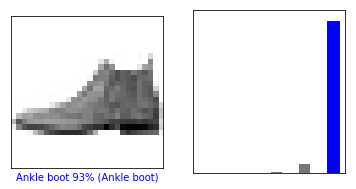

In [33]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

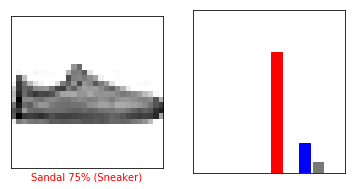

In [34]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident.

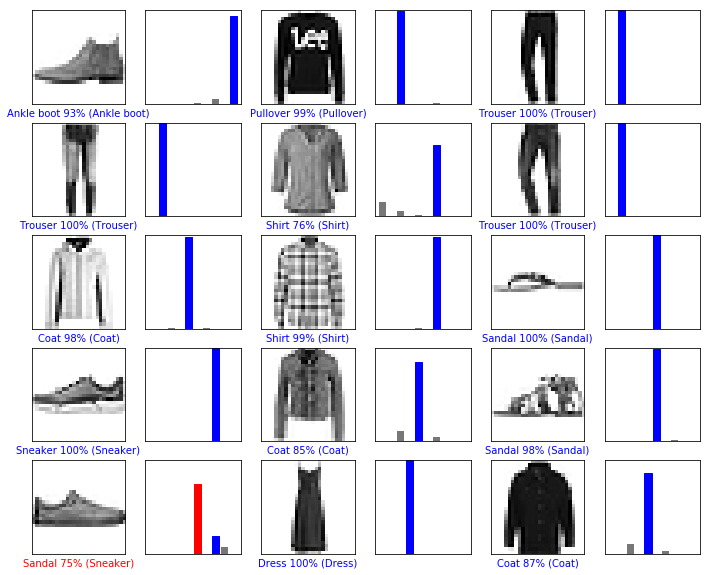

In [35]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

Finally, use the trained model to make a prediction about a single image.

In [36]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28)


tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [37]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Now predict the image:

In [38]:
predictions_single = model.predict(img)

print(predictions_single)

[[7.3580259e-07 3.9332107e-08 1.1762108e-06 6.5100647e-07 2.4366969e-07
  9.2866290e-03 2.1586918e-06 5.5848856e-02 5.2370870e-06 9.3485427e-01]]


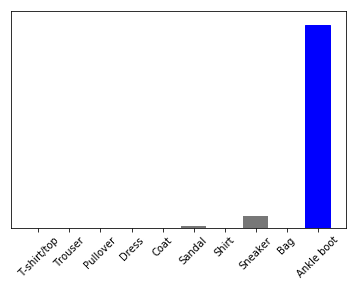

In [40]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

model.predict returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [42]:
np.argmax(predictions_single[0])

9

And, as before, the model predicts a label of 9.